# TinyML-Autopilot Processor Comparison Analysis

This notebook analyzes the performance comparison between **PSG** and **TPUSG** processors across different models and parameter configurations.

## Core Analysis Framework:
- **2 Processors**: PSG vs TPUSG  
- **5 Models**: qwen32b, qwen14b, phi4, gemma3:27b, codestral
- **2 Conditions**: With Parameters vs Without Parameters
- **Goal**: Determine which processor performs better under different configurations

### Combine csv files

In [ ]:
import glob
import os
from pathlib import Path

import pandas as pd


def combine_csv_files():
    # %%
    # Base directory for data analysis
    base_dir = "/Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025"
    
    # Pattern to find all CSV files
    # The folder name need to be something greater than 05 as the leading two numbers separated by dot. 
    
    
    
    # List all folders in base_dir and filter those with leading numbers > 05
    valid_folders = []
    for folder in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, folder)):
            parts = folder.split('.')
            if len(parts) >= 2 and parts[0].isdigit() and int(parts[0]) >= 4:
                valid_folders.append(folder)

    # Build glob patterns for each valid folder
    csv_files = []
    for folder in valid_folders:
        pattern = os.path.join(base_dir, folder, "processed_data", "**", "*.csv")
        csv_files.extend(glob.glob(pattern, recursive=True))
    
    # Find all CSV files
    # csv_files = glob.glob(csv_pattern, recursive=True)
    print(f"Valid folders found: {valid_folders}")
    print(f"Found {len(csv_files)} CSV files to combine")
    
    
    # %%
    # List to store all dataframes
    all_dataframes = []
    
    # Process each CSV file
    for csv_file in csv_files:
        try:
            # Read the CSV file
            df = pd.read_csv(csv_file)
            
            # Add metadata columns for tracking
            df['source_file'] = os.path.basename(csv_file)
            df['source_path'] = csv_file
            
            # Extract date from path (e.g., "07.29" from path)
            path_parts = Path(csv_file).parts
            date_index = next((i for i, part in enumerate(path_parts) if part == "2025"), None)
            if date_index and date_index + 1 < len(path_parts):
                df['test_date'] = path_parts[date_index + 1]
            else:
                df['test_date'] = 'unknown'
            
            # Extract model info from the processed_data folder name
            processed_data_index = next((i for i, part in enumerate(path_parts) if part == "processed_data"), None)
            if processed_data_index and processed_data_index + 1 < len(path_parts):
                df['model_config'] = path_parts[processed_data_index + 1]
            else:
                df['model_config'] = 'unknown'
            
            all_dataframes.append(df)
            print(f"Processed: {csv_file} - {len(df)} rows")
            
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
    
    if not all_dataframes:
        print("No CSV files were successfully processed!")
        return
    
    # Combine all dataframes
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    combined_df['generation_count'] = combined_df['generation_count'].astype(int)
    # Sort by batch_id and then by num_run if available
    if 'batch_id' in combined_df.columns:
        sort_columns = ['batch_id']
        if 'num_run' in combined_df.columns:
            sort_columns.append('num_run')
        combined_df = combined_df.sort_values(sort_columns)
    
    # Output file path
    output_file = "/Users/hann/Projects/reference-benchmark-tinyml_llm/combined_tinyml_benchmark_data.csv"
    
    # Save combined CSV
    combined_df.to_csv(output_file, index=False)
    
    print(f"\nCombined data saved to: {output_file}")
    print(f"Total rows: {len(combined_df)}")
    print(f"Total unique batch_ids: {combined_df['batch_id'].nunique()}")
    
    # Display summary statistics
    print("\nBatch ID Summary:")
    batch_summary = combined_df['batch_id'].value_counts().head(20)
    print(batch_summary)
    
    print("\nTest Date Summary:")
    date_summary = combined_df['test_date'].value_counts()
    print(date_summary)
    
    print("\nModel Configuration Summary:")
    model_summary = combined_df['model_config'].value_counts()
    print(model_summary)
    
    return output_file


combine_csv_files()

In [529]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

def model_config_trim(value):
    value = value.split("_")[0]
    if "qwen2.5-coder" in value:
        value = value.replace("qwen2.5-coder:", "qwen")
    
    return value

# More robust processor type extraction
def extract_processor(batch_id):
    if 'psg' in batch_id:
        return 'psg'
    elif 'tpusg' in batch_id:
        return 'tpusg'
    elif 'tpsg' in batch_id:
        return 'tpusg'
    elif 'sg' in batch_id:
        return 'sg'
    elif 'dp' in batch_id:
        return 'dp'
    elif 'mc' in batch_id:
        return 'mc'
    else:
        return 'unknown'

# Weighted success rate calculation functions
def calculate_weighted_rates(data_group):
    """Calculate weighted success rates considering generation attempts"""
    # Get successful runs only
    success_data = data_group[data_group['status'] == 'success']
    total_runs = len(data_group)
    
    if success_data.empty or 'generation_count' not in success_data.columns:
        # Return traditional success rate if no generation_count or no successes
        traditional_rate = len(success_data) / total_runs if total_runs > 0 else 0
        return {
            'traditional_success_rate': traditional_rate * 100,
            'efficiency_weighted_rate': traditional_rate * 100,
            'exponential_weighted_rate': traditional_rate * 100, 
            'linear_weighted_rate': traditional_rate * 100,
            'robust_weighted_rate': traditional_rate * 100
        }
    
    # Traditional success rate
    traditional_rate = len(success_data) / total_runs * 100
    
    # Method 1: Efficiency-weighted (1/generation_count)
    efficiency_scores = 1 / success_data['generation_count']
    efficiency_weighted_rate = efficiency_scores.sum() / total_runs * 100
    
    # Method 2: Exponential penalty  
    exponential_scores = np.exp(-0.5 * (success_data['generation_count'] - 1))
    exponential_weighted_rate = exponential_scores.sum() / total_runs * 100
    
    # Method 3: Linear penalty
    linear_scores = 1 - 0.2 * (success_data['generation_count'] - 1)  # 20% penalty per extra generation
    linear_scores = np.maximum(linear_scores, 0.1)  # Minimum score of 0.1
    linear_weighted_rate = linear_scores.sum() / total_runs * 100
    
    # Method 4: Robust/Rank-based (step/bucket approach)
    def robust_score(gen_count):
        if gen_count <= 2:  # First 2 attempts = full credit
            return 1.0
        elif gen_count <= 4:  # 3-4 attempts = partial credit
            return 0.6
        elif gen_count <= 6:  # 5-6 attempts = lower credit
            return 0.3
        else:  # 7+ attempts = minimal credit
            return 0.1
    
    robust_scores = success_data['generation_count'].apply(robust_score)
    robust_weighted_rate = robust_scores.sum() / total_runs * 100
    
    return {
        'traditional_success_rate': traditional_rate,
        'efficiency_weighted_rate': efficiency_weighted_rate,
        'exponential_weighted_rate': exponential_weighted_rate,
        'linear_weighted_rate': linear_weighted_rate,
        'robust_weighted_rate': robust_weighted_rate
    }

In [530]:
# Load the Combined CSV Dataset
csv_path = "/Users/hann/Projects/reference-benchmark-tinyml_llm/combined_tinyml_benchmark_data.csv"

# Read and clean the dataset
df = pd.read_csv(csv_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")

# Clean and prepare data
df.drop(columns=['source_file','trace_id', 'source_path','prompt_cost', 'completion_cost','total_cost'], inplace=True)
df['model_config'] = df['model_config'].apply(model_config_trim)
df['parameters'] = df['parameters'].apply(lambda x: False if pd.isna(x) else len(str(x)) > 0)
df['batch_id'] = df['batch_id'].str.replace("qwen2.5-coder:", "qwen").str.replace("_batch", "")

# Filter data from July onwards and extract processor type
df = df[df['test_date'].str.split('.').str[0].astype(int)>=7]
df['processor'] = df['batch_id'].map(extract_processor)

# All rules in the format (processor, model, parameter, category_name)
rules = [
    ('psg',   'qwen32b',   True,  'psg-qwen32b-True'),
    ('psg',   'qwen32b',   False, 'psg-qwen32b-False'),
    ('psg',   'qwen14b',   True,  'psg-qwen14b-True'),
    ('psg',   'qwen14b',   False, 'psg-qwen14b-False'),
    ('psg',   'phi4',      True,  'psg-phi4-True'),
    ('psg',   'phi4',      False, 'psg-phi4-False'),
    ('psg',   'gemma3:27b',True,  'psg-gemma3:27b-True'),
    ('psg',   'gemma3:27b',False, 'psg-gemma3:27b-False'),
    ('psg',   'codestral', True,  'psg-codestral-True'),
    ('psg',   'codestral', False, 'psg-codestral-False'),

    ('tpusg', 'qwen32b',   True,  'tpusg-qwen32b-True'),
    ('tpusg', 'qwen32b',   False, 'tpusg-qwen32b-False'),
    ('tpusg', 'qwen14b',   True,  'tpusg-qwen14b-True'),
    ('tpusg', 'qwen14b',   False, 'tpusg-qwen14b-False'),
    ('tpusg', 'phi4',      True,  'tpusg-phi4-True'),
    ('tpusg', 'phi4',      False, 'tpusg-phi4-False'),
    ('tpusg', 'gemma3:27b',True,  'tpusg-gemma3:27b-True'),
    ('tpusg', 'gemma3:27b',False, 'tpusg-gemma3:27b-False'),
    ('tpusg', 'codestral', True,  'tpusg-codestral-True'),
    ('tpusg', 'codestral', False, 'tpusg-codestral-False'),
]

# Build conditions and choices
conditions = [
    (df['processor'] == proc) &
    (df['model_config'] == model) &
    (df['parameters'] == param)
    for proc, model, param, _ in rules
]
choices = [category for _, _, _, category in rules]

# Create category column
df['category'] = np.select(conditions, choices, default='Other')

print(f"Final shape: {df.shape}")
print(f"Processor distribution: {df['processor'].value_counts().to_dict()}")
print(f"Parameter distribution: {df['parameters'].value_counts().to_dict()}")
print(f"Category distribution: {df['category'].value_counts().to_dict()}")
df.head()

Dataset loaded successfully!
Shape: (1188, 20)
Final shape: (1068, 16)
Processor distribution: {'psg': 545, 'tpusg': 523}
Parameter distribution: {True: 648, False: 420}
Category distribution: {'psg-qwen32b-True': 136, 'tpusg-qwen32b-True': 120, 'tpusg-qwen32b-False': 90, 'psg-qwen14b-True': 87, 'tpusg-phi4-True': 60, 'psg-qwen32b-False': 60, 'tpusg-qwen14b-True': 60, 'psg-codestral-True': 60, 'tpusg-codestral-False': 60, 'psg-gemma3:27b-True': 52, 'tpusg-gemma3:27b-True': 43, 'psg-phi4-True': 30, 'psg-codestral-False': 30, 'tpusg-phi4-False': 30, 'tpusg-gemma3:27b-False': 30, 'psg-gemma3:27b-False': 30, 'psg-qwen14b-False': 30, 'tpusg-qwen14b-False': 30, 'psg-phi4-False': 30}


,num_run,name,batch_id,status,latency,total_tokens,prompt_tokens,completion_tokens,parameters,generation_count,tags,timestamp,test_date,model_config,processor,category
30,1,24c0_py_sketch_generator,codestral_3adb_psg,failure,79.15,12729,10052,2677,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402461,08.08,codestral,psg,psg-codestral-True
31,2,7881_py_sketch_generator,codestral_3adb_psg,failure,98.48,13489,10052,3437,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402548,08.08,codestral,psg,psg-codestral-True
32,3,fafb_py_sketch_generator,codestral_3adb_psg,success,104.55,13731,10052,3679,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402654,08.08,codestral,psg,psg-codestral-True
33,4,e270_py_sketch_generator,codestral_3adb_psg,failure,94.43,13304,10052,3252,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402766,08.08,codestral,psg,psg-codestral-True
34,5,6ef4_py_sketch_generator,codestral_3adb_psg,failure,102.78,13653,10052,3601,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402868,08.08,codestral,psg,psg-codestral-True


## Processor Performance Comparison

Direct comparison between PSG and TPUSG processors across all model configurations and parameter conditions.

In [531]:
# Core Processor Comparison Analysis
print("🔄 PROCESSOR COMPARISON: PSG vs TPUSG")
print("=" * 60)

# Calculate success rates for each combination
comparison_df = df.groupby(['processor', 'model_config', 'parameters']).agg({
    'status': ['count', lambda x: (x == 'success').sum()],
    'total_tokens': 'mean'
}).round(2)

comparison_df.columns = ['total_runs', 'successes', 'avg_tokens']
comparison_df['success_rate'] = (comparison_df['successes'] / comparison_df['total_runs'] * 100).round(2)

# Calculate weighted success rates for each group
weighted_rates_list = []
for (processor, model_config, parameters), group in df.groupby(['processor', 'model_config', 'parameters']):
    weighted_rates = calculate_weighted_rates(group)
    weighted_rates_list.append({
        'processor': processor,
        'model_config': model_config, 
        'parameters': parameters,
        **weighted_rates
    })

# Convert to DataFrame and merge with comparison_df
weighted_df = pd.DataFrame(weighted_rates_list)
comparison_df = comparison_df.reset_index()

# Merge the weighted rates
comparison_df = comparison_df.merge(
    weighted_df[['processor', 'model_config', 'parameters', 
                'efficiency_weighted_rate', 'exponential_weighted_rate', 
                'linear_weighted_rate', 'robust_weighted_rate']], 
    on=['processor', 'model_config', 'parameters'], 
    how='left'
)

# Round weighted rates to 2 decimal places
for col in ['efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    comparison_df[col] = comparison_df[col].round(2)

print(f"📊 Data Summary:")
print(f"Total test runs: {len(df)}")
print(f"PSG runs: {len(df[df['processor'] == 'psg'])}")
print(f"TPUSG runs: {len(df[df['processor'] == 'tpusg'])}")
print(f"Models tested: {', '.join(sorted(df['model_config'].unique()))}")
print(f"Parameter conditions: With params ({len(df[df['parameters'] == True])}) vs Without params ({len(df[df['parameters'] == False])})")

print(f"\n📈 Complete Processor Comparison Matrix:")
print("-" * 60)

# Create a comprehensive comparison table
pivot_table = comparison_df.pivot_table(
    values='success_rate',
    index=['model_config', 'parameters'], 
    columns='processor',
    fill_value=0
).round(1)

print(pivot_table)

# Calculate processor advantage
print(f"\n🎯 PROCESSOR ADVANTAGE ANALYSIS:")
print("-" * 60)

advantage_data = []
for model in comparison_df['model_config'].unique():
    for param_condition in [True, False]:
        model_data = comparison_df[
            (comparison_df['model_config'] == model) & 
            (comparison_df['parameters'] == param_condition)
        ]
        
        if len(model_data) == 2:  # Both processors tested
            psg_rate = model_data[model_data['processor'] == 'psg']['success_rate'].iloc[0]
            tpusg_rate = model_data[model_data['processor'] == 'tpusg']['success_rate'].iloc[0]
            advantage = tpusg_rate - psg_rate
            winner = 'TPUSG' if advantage > 0 else 'PSG' if advantage < 0 else 'TIE'
            
            advantage_data.append({
                'model': model,
                'parameters': 'With' if param_condition else 'Without',
                'psg_rate': psg_rate,
                'tpusg_rate': tpusg_rate,
                'advantage': advantage,
                'winner': winner
            })

advantage_df = pd.DataFrame(advantage_data)

# Display advantage analysis
for _, row in advantage_df.iterrows():
    param_str = row['parameters']
    print(f"{row['model']} ({param_str} params): PSG {row['psg_rate']:.1f}% vs TPUSG {row['tpusg_rate']:.1f}% → {row['winner']} (+{row['advantage']:.1f}%)")

# Summary statistics
psg_wins = len(advantage_df[advantage_df['winner'] == 'PSG'])
tpusg_wins = len(advantage_df[advantage_df['winner'] == 'TPUSG'])
ties = len(advantage_df[advantage_df['winner'] == 'TIE'])

print(f"\n📊 SUMMARY:")
print(f"PSG wins: {psg_wins}/{len(advantage_df)} configurations")
print(f"TPUSG wins: {tpusg_wins}/{len(advantage_df)} configurations") 
print(f"Ties: {ties}/{len(advantage_df)} configurations")

# Display comparison_df with all rates for verification
print(f"\n📋 COMPLETE COMPARISON TABLE (Traditional + Weighted Success Rates):")
print("-" * 100)
display_columns = ['processor', 'model_config', 'parameters', 'total_runs', 'successes', 
                   'success_rate', 'efficiency_weighted_rate', 'exponential_weighted_rate', 
                   'linear_weighted_rate', 'robust_weighted_rate', 'avg_tokens']
comparison_df[display_columns]

🔄 PROCESSOR COMPARISON: PSG vs TPUSG
📊 Data Summary:
Total test runs: 1068
PSG runs: 545
TPUSG runs: 523
Models tested: codestral, gemma3:27b, phi4, qwen14b, qwen32b
Parameter conditions: With params (648) vs Without params (420)

📈 Complete Processor Comparison Matrix:
------------------------------------------------------------
processor                  psg  tpusg
model_config parameters              
codestral    False        16.7   33.3
             True          5.0    0.0
gemma3:27b   False        80.0    3.3
             True         71.2    0.0
phi4         False        60.0  100.0
             True        100.0  100.0
qwen14b      False        26.7   46.7
             True          4.6  100.0
qwen32b      False        50.0   96.7
             True         39.7   35.0

🎯 PROCESSOR ADVANTAGE ANALYSIS:
------------------------------------------------------------
codestral (Without params): PSG 16.7% vs TPUSG 33.3% → TPUSG (+16.7%)
gemma3:27b (With params): PSG 71.2% vs TPUSG 0.0

,processor,model_config,parameters,total_runs,successes,success_rate,efficiency_weighted_rate,exponential_weighted_rate,linear_weighted_rate,robust_weighted_rate,avg_tokens
0,psg,codestral,False,30,5,16.67,7.22,7.27,10.00,11.33,12638.83
1,psg,codestral,True,60,3,5.00,1.22,1.06,1.67,2.00,13372.43
2,psg,gemma3:27b,False,30,24,80.00,42.78,45.71,58.00,65.33,7677.13
3,psg,gemma3:27b,True,52,37,71.15,15.58,11.99,19.62,29.42,12714.37
4,psg,phi4,False,30,18,60.00,31.00,30.48,36.67,41.33,10342.07
5,psg,phi4,True,30,30,100.00,100.00,100.00,100.00,100.00,2242.70
6,psg,qwen14b,False,30,8,26.67,16.89,16.69,18.67,19.33,10776.90
7,psg,qwen14b,True,87,4,4.60,1.38,1.37,2.07,2.87,11955.85
8,psg,qwen32b,False,60,30,50.00,35.53,36.00,40.00,42.33,9810.17
9,psg,qwen32b,True,136,54,39.71,9.62,8.19,12.94,18.09,13483.35


## Visualization & Insights

Comprehensive visual analysis and strategic recommendations for processor selection.


📊 CREATING PROCESSOR COMPARISON VISUALIZATIONS


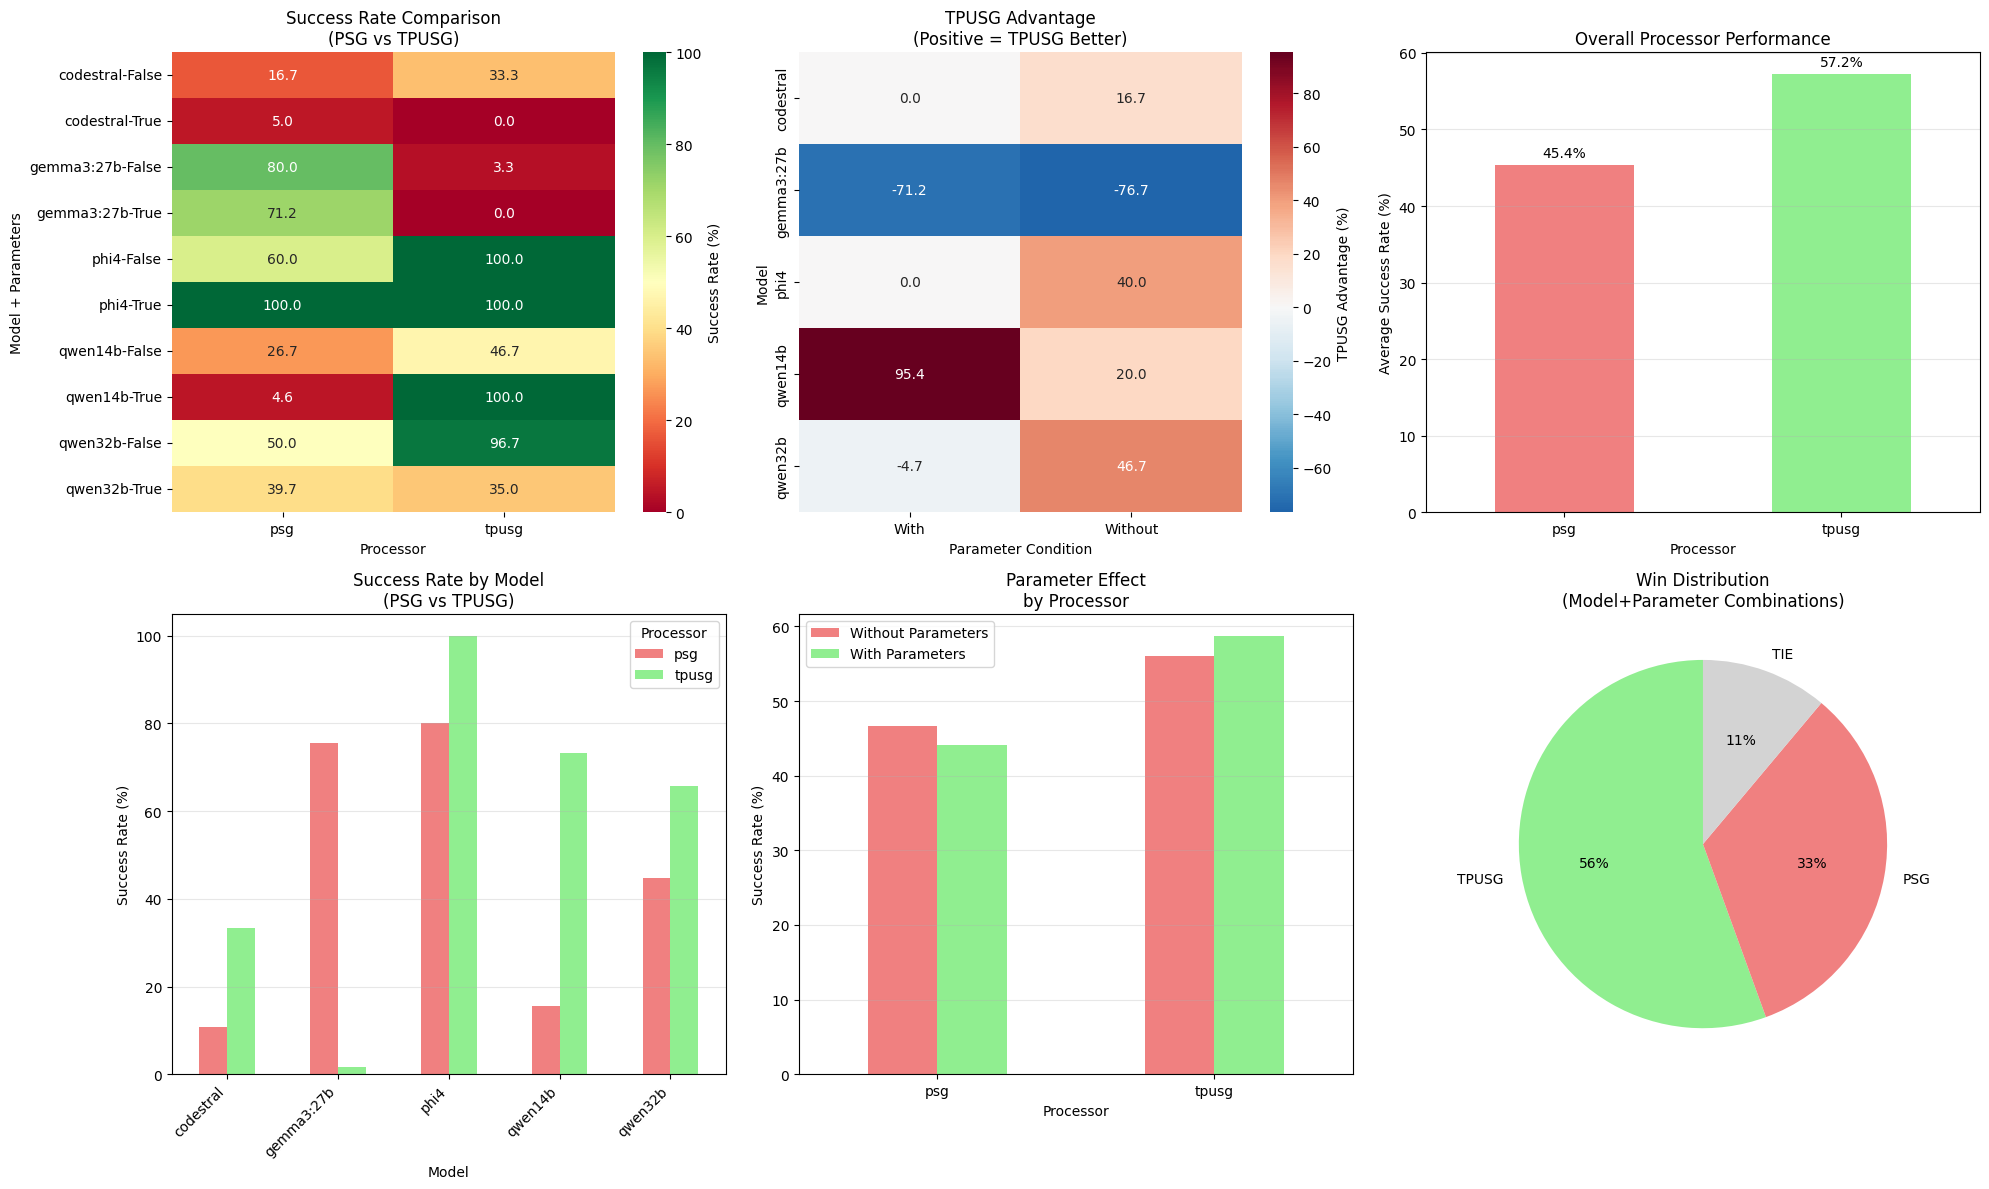

✅ Processor comparison visualizations created successfully!
📊 Analysis shows clear performance differences between PSG and TPUSG processors


In [532]:
# Processor Comparison Visualizations
print("\n📊 CREATING PROCESSOR COMPARISON VISUALIZATIONS")
print("=" * 60)

fig = plt.figure(figsize=(20, 12))

# 1. Head-to-Head Comparison Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Success Rate (%)'}, ax=ax1)
ax1.set_title('Success Rate Comparison\n(PSG vs TPUSG)')
ax1.set_xlabel('Processor')
ax1.set_ylabel('Model + Parameters')

# 2. Advantage Heatmap (TPUSG - PSG)
ax2 = plt.subplot(2, 3, 2)
advantage_pivot = advantage_df.pivot_table(
    values='advantage',
    index='model',
    columns='parameters',
    fill_value=0
).round(1)

sns.heatmap(advantage_pivot, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'TPUSG Advantage (%)'}, ax=ax2)
ax2.set_title('TPUSG Advantage\n(Positive = TPUSG Better)')
ax2.set_xlabel('Parameter Condition')
ax2.set_ylabel('Model')

# 3. Overall Processor Performance
ax3 = plt.subplot(2, 3, 3)
overall_performance = comparison_df.groupby('processor')['success_rate'].mean()
bars = overall_performance.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightgreen'])
ax3.set_title('Overall Processor Performance')
ax3.set_ylabel('Average Success Rate (%)')
ax3.set_xlabel('Processor')
plt.xticks(rotation=0)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(overall_performance.values):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center')

# 4. Model-by-Model Comparison
ax4 = plt.subplot(2, 3, 4)
model_comparison = comparison_df.groupby(['model_config', 'processor'])['success_rate'].mean().unstack()
model_comparison.plot(kind='bar', ax=ax4, color=['lightcoral', 'lightgreen'])
ax4.set_title('Success Rate by Model\n(PSG vs TPUSG)')
ax4.set_xlabel('Model')
ax4.set_ylabel('Success Rate (%)')
ax4.legend(title='Processor')
plt.xticks(rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Parameter Effect Comparison
ax5 = plt.subplot(2, 3, 5)
param_effect = comparison_df.groupby(['processor', 'parameters'])['success_rate'].mean().unstack()
param_effect.columns = ['Without Parameters', 'With Parameters']
param_effect.plot(kind='bar', ax=ax5, color=['lightcoral', 'lightgreen'])
ax5.set_title('Parameter Effect\nby Processor')
ax5.set_xlabel('Processor')
ax5.set_ylabel('Success Rate (%)')
ax5.legend()
plt.xticks(rotation=0)
ax5.grid(axis='y', alpha=0.3)

# 6. Win Distribution
ax6 = plt.subplot(2, 3, 6)
win_counts = advantage_df['winner'].value_counts()
colors_pie = ['lightgreen' if x == 'TPUSG' else 'lightcoral' if x == 'PSG' else 'lightgray' for x in win_counts.index]
ax6.pie(win_counts.values, labels=win_counts.index, autopct='%1.0f%%', 
        colors=colors_pie, startangle=90)
ax6.set_title('Win Distribution\n(Model+Parameter Combinations)')

plt.tight_layout()
plt.show()

print("✅ Processor comparison visualizations created successfully!")
print(f"📊 Analysis shows clear performance differences between PSG and TPUSG processors")

In [533]:
# Processor Comparison Insights & Recommendations
print("\n🎓 PROCESSOR COMPARISON INSIGHTS")
print("=" * 60)

# Overall processor performance - Traditional + Weighted
print(f"📊 OVERALL PERFORMANCE:")

psg_overall = comparison_df[comparison_df['processor'] == 'psg']['success_rate'].mean()
tpusg_overall = comparison_df[comparison_df['processor'] == 'tpusg']['success_rate'].mean()

print(f"Traditional Success Rate:")
print(f"  PSG Average: {psg_overall:.1f}%")
print(f"  TPUSG Average: {tpusg_overall:.1f}%")
print(f"  Overall Winner: {'TPUSG' if tpusg_overall > psg_overall else 'PSG'} (+{abs(tpusg_overall - psg_overall):.1f}%)")

# Weighted averages
for method in ['efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    psg_weighted = comparison_df[comparison_df['processor'] == 'psg'][method].mean()
    tpusg_weighted = comparison_df[comparison_df['processor'] == 'tpusg'][method].mean()
    winner = 'TPUSG' if tpusg_weighted > psg_weighted else 'PSG'
    diff = abs(tpusg_weighted - psg_weighted)
    
    method_name = method.replace('_weighted_rate', '').replace('_', ' ').title()
    print(f"{method_name} Weighted:")
    print(f"  PSG Average: {psg_weighted:.1f}%")
    print(f"  TPUSG Average: {tpusg_weighted:.1f}%")
    print(f"  Winner: {winner} (+{diff:.1f}%)")

# Parameter effect analysis - Traditional + Weighted
print(f"\n⚙️ PARAMETER EFFECTS:")

# Traditional rates
psg_with_params = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['success_rate'].mean()
psg_without_params = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['success_rate'].mean()
tpusg_with_params = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['success_rate'].mean()
tpusg_without_params = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['success_rate'].mean()

print(f"Traditional Success Rate:")
print(f"  PSG: With params {psg_with_params:.1f}% vs Without params {psg_without_params:.1f}% (Effect: {psg_with_params - psg_without_params:+.1f}%)")
print(f"  TPUSG: With params {tpusg_with_params:.1f}% vs Without params {tpusg_without_params:.1f}% (Effect: {tpusg_with_params - tpusg_without_params:+.1f}%)")

# Weighted parameter effects
for method in ['efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    psg_with = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)][method].mean()
    psg_without = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)][method].mean()
    tpusg_with = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)][method].mean()
    tpusg_without = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)][method].mean()
    
    method_name = method.replace('_weighted_rate', '').replace('_', ' ').title()
    print(f"{method_name} Weighted:")
    print(f"  PSG: With params {psg_with:.1f}% vs Without params {psg_without:.1f}% (Effect: {psg_with - psg_without:+.1f}%)")
    print(f"  TPUSG: With params {tpusg_with:.1f}% vs Without params {tpusg_without:.1f}% (Effect: {tpusg_with - tpusg_without:+.1f}%)")

# Model-specific recommendations
print(f"\n💡 MODEL-SPECIFIC RECOMMENDATIONS:")
for model in sorted(comparison_df['model_config'].unique()):
    model_data = advantage_df[advantage_df['model'] == model]
    
    if len(model_data) > 0:
        best_configs = []
        for _, row in model_data.iterrows():
            if row['winner'] != 'TIE':
                param_str = row['parameters'].lower()
                best_configs.append(f"{row['winner']} {param_str} params ({row[row['winner'].lower() + '_rate']:.1f}%)")
        
        if best_configs:
            best_config = max(best_configs, key=lambda x: float(x.split('(')[1].split('%')[0]))
            print(f"   {model}: {best_config}")

# Strategic insights
psg_wins = len(advantage_df[advantage_df['winner'] == 'PSG'])
tpusg_wins = len(advantage_df[advantage_df['winner'] == 'TPUSG'])
ties = len(advantage_df[advantage_df['winner'] == 'TIE'])

print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
print(f"   Primary: Use {'TPUSG' if tpusg_wins > psg_wins else 'PSG'} (wins {max(psg_wins, tpusg_wins)}/{len(advantage_df)} comparisons)")
print(f"   Secondary: {'PSG' if tpusg_wins > psg_wins else 'TPUSG'} for specific model configurations where it excels")

print(f"\n⚙️ PARAMETER USAGE STRATEGY:")
print(f"   PSG: Parameters {'help' if psg_with_params > psg_without_params else 'hurt'} performance ({psg_with_params - psg_without_params:+.1f}%)")
print(f"   TPUSG: Parameters {'help' if tpusg_with_params > tpusg_without_params else 'hurt'} performance ({tpusg_with_params - tpusg_without_params:+.1f}%)")

print(f"\n✅ PROCESSOR COMPARISON ANALYSIS COMPLETE!")
print(f"📈 Analyzed {len(comparison_df)} processor-model-parameter combinations")
print(f"🎯 Traditional winner: {'TPUSG' if tpusg_overall > psg_overall else 'PSG'}")

# Show efficiency impact summary
print(f"\n🔄 GENERATION EFFICIENCY IMPACT:")
print(f"Traditional vs Efficiency-weighted success rates show the impact of generation attempts.")
efficiency_psg = comparison_df[comparison_df['processor'] == 'psg']['efficiency_weighted_rate'].mean()
efficiency_tpusg = comparison_df[comparison_df['processor'] == 'tpusg']['efficiency_weighted_rate'].mean()
print(f"Efficiency-weighted winner: {'TPUSG' if efficiency_tpusg > efficiency_psg else 'PSG'}")
print(f"This accounts for the number of generation attempts needed for success.")


🎓 PROCESSOR COMPARISON INSIGHTS
📊 OVERALL PERFORMANCE:
Traditional Success Rate:
  PSG Average: 45.4%
  TPUSG Average: 57.2%
  Overall Winner: TPUSG (+11.8%)
Efficiency Weighted:
  PSG Average: 26.1%
  TPUSG Average: 45.7%
  Winner: TPUSG (+19.6%)
Exponential Weighted:
  PSG Average: 25.9%
  TPUSG Average: 46.6%
  Winner: TPUSG (+20.7%)
Linear Weighted:
  PSG Average: 30.0%
  TPUSG Average: 50.1%
  Winner: TPUSG (+20.2%)
Robust Weighted:
  PSG Average: 33.2%
  TPUSG Average: 52.7%
  Winner: TPUSG (+19.5%)

⚙️ PARAMETER EFFECTS:
Traditional Success Rate:
  PSG: With params 44.1% vs Without params 46.7% (Effect: -2.6%)
  TPUSG: With params 58.8% vs Without params 56.0% (Effect: +2.8%)
Efficiency Weighted:
  PSG: With params 25.6% vs Without params 26.7% (Effect: -1.1%)
  TPUSG: With params 52.4% vs Without params 40.4% (Effect: +11.9%)
Exponential Weighted:
  PSG: With params 24.5% vs Without params 27.2% (Effect: -2.7%)
  TPUSG: With params 52.3% vs Without params 42.1% (Effect: +10.2%


📊 TRADITIONAL vs WEIGHTED SUCCESS RATES COMPARISON


/var/folders/fk/pd_cb7_x7k3bl94y8nq4shgw0000gn/T/ipykernel_69053/115399191.py:145: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fk/pd_cb7_x7k3bl94y8nq4shgw0000gn/T/ipykernel_69053/115399191.py:145: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fk/pd_cb7_x7k3bl94y8nq4shgw0000gn/T/ipykernel_69053/115399191.py:145: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hann/anaconda3/envs/datasci2/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hann/anaconda3/envs/datasci2/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

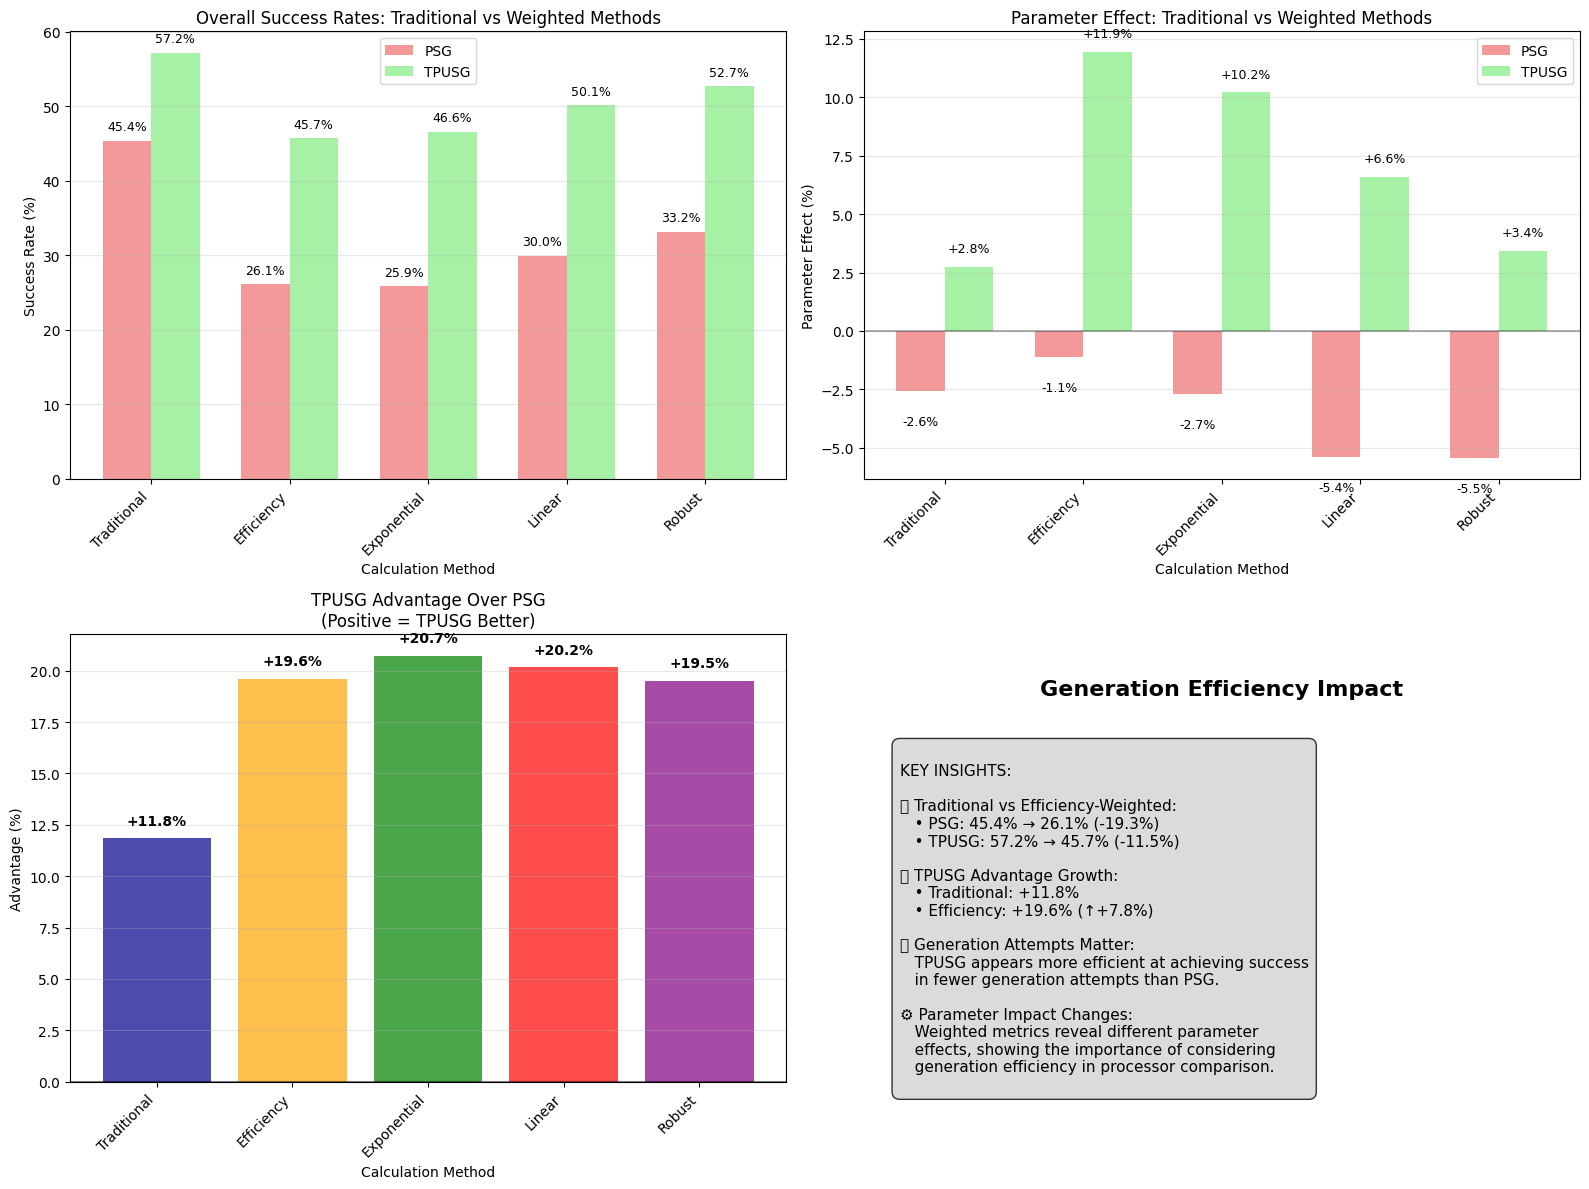

✅ Weighted success rate analysis complete!
📈 The efficiency-weighted metrics show TPUSG has a 19.6% advantage vs 11.8% traditional.


In [534]:
# Weighted vs Traditional Success Rate Comparison Visualization
print("\n📊 TRADITIONAL vs WEIGHTED SUCCESS RATES COMPARISON")
print("=" * 70)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Performance Comparison (Traditional vs Efficiency-weighted)
methods = ['Traditional', 'Efficiency', 'Exponential', 'Linear', 'Robust']
psg_rates = [
    comparison_df[comparison_df['processor'] == 'psg']['success_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['efficiency_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['exponential_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['linear_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['robust_weighted_rate'].mean()
]
tpusg_rates = [
    comparison_df[comparison_df['processor'] == 'tpusg']['success_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['efficiency_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['exponential_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['linear_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['robust_weighted_rate'].mean()
]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, psg_rates, width, label='PSG', color='lightcoral', alpha=0.8)
bars2 = ax1.bar(x + width/2, tpusg_rates, width, label='TPUSG', color='lightgreen', alpha=0.8)

ax1.set_title('Overall Success Rates: Traditional vs Weighted Methods')
ax1.set_xlabel('Calculation Method')
ax1.set_ylabel('Success Rate (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, (p, t) in enumerate(zip(psg_rates, tpusg_rates)):
    ax1.text(i - width/2, p + 1, f'{p:.1f}%', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, t + 1, f'{t:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Parameter Effect Comparison
param_methods = ['Traditional', 'Efficiency', 'Exponential', 'Linear', 'Robust']
psg_param_effect = [
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['success_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['success_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['efficiency_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['efficiency_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['exponential_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['exponential_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['linear_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['linear_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['robust_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['robust_weighted_rate'].mean()
]

tpusg_param_effect = [
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['success_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['success_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['efficiency_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['efficiency_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['exponential_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['exponential_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['linear_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['linear_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['robust_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['robust_weighted_rate'].mean()
]

x2 = np.arange(len(param_methods))
bars3 = ax2.bar(x2 - width/2, psg_param_effect, width, label='PSG', color='lightcoral', alpha=0.8)
bars4 = ax2.bar(x2 + width/2, tpusg_param_effect, width, label='TPUSG', color='lightgreen', alpha=0.8)

ax2.set_title('Parameter Effect: Traditional vs Weighted Methods')
ax2.set_xlabel('Calculation Method')
ax2.set_ylabel('Parameter Effect (%)')
ax2.set_xticks(x2)
ax2.set_xticklabels(param_methods, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels
for i, (p, t) in enumerate(zip(psg_param_effect, tpusg_param_effect)):
    ax2.text(i - width/2, p + 0.5 if p > 0 else p - 1, f'{p:+.1f}%', ha='center', va='bottom' if p > 0 else 'top', fontsize=9)
    ax2.text(i + width/2, t + 0.5 if t > 0 else t - 1, f'{t:+.1f}%', ha='center', va='bottom' if t > 0 else 'top', fontsize=9)

# 3. Advantage Gap Analysis
advantages = []
for method in ['success_rate', 'efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    psg_avg = comparison_df[comparison_df['processor'] == 'psg'][method].mean()
    tpusg_avg = comparison_df[comparison_df['processor'] == 'tpusg'][method].mean()
    advantages.append(tpusg_avg - psg_avg)

colors = ['darkblue', 'orange', 'green', 'red', 'purple']
bars5 = ax3.bar(methods, advantages, color=colors, alpha=0.7)
ax3.set_title('TPUSG Advantage Over PSG\n(Positive = TPUSG Better)')
ax3.set_xlabel('Calculation Method')
ax3.set_ylabel('Advantage (%)')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(advantages):
    ax3.text(i, v + 0.5 if v > 0 else v - 1, f'{v:+.1f}%', ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

# 4. Efficiency Impact Visualization
ax4.axis('off')
ax4.text(0.5, 0.9, 'Generation Efficiency Impact', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax4.transAxes)

summary_text = f"""
KEY INSIGHTS:

🎯 Traditional vs Efficiency-Weighted:
   • PSG: {psg_rates[0]:.1f}% → {psg_rates[1]:.1f}% ({psg_rates[1]-psg_rates[0]:+.1f}%)
   • TPUSG: {tpusg_rates[0]:.1f}% → {tpusg_rates[1]:.1f}% ({tpusg_rates[1]-tpusg_rates[0]:+.1f}%)

📊 TPUSG Advantage Growth:
   • Traditional: +{advantages[0]:.1f}%
   • Efficiency: +{advantages[1]:.1f}% (↑{advantages[1]-advantages[0]:+.1f}%)

🔄 Generation Attempts Matter:
   TPUSG appears more efficient at achieving success
   in fewer generation attempts than PSG.

⚙️ Parameter Impact Changes:
   Weighted metrics reveal different parameter
   effects, showing the importance of considering
   generation efficiency in processor comparison.
"""

ax4.text(0.05, 0.75, summary_text, ha='left', va='top', fontsize=11, transform=ax4.transAxes, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Weighted success rate analysis complete!")
print(f"📈 The efficiency-weighted metrics show TPUSG has a {advantages[1]:.1f}% advantage vs {advantages[0]:.1f}% traditional.")


📊 DETAILED PROCESSOR COMPARISON BY MODEL & PARAMETERS


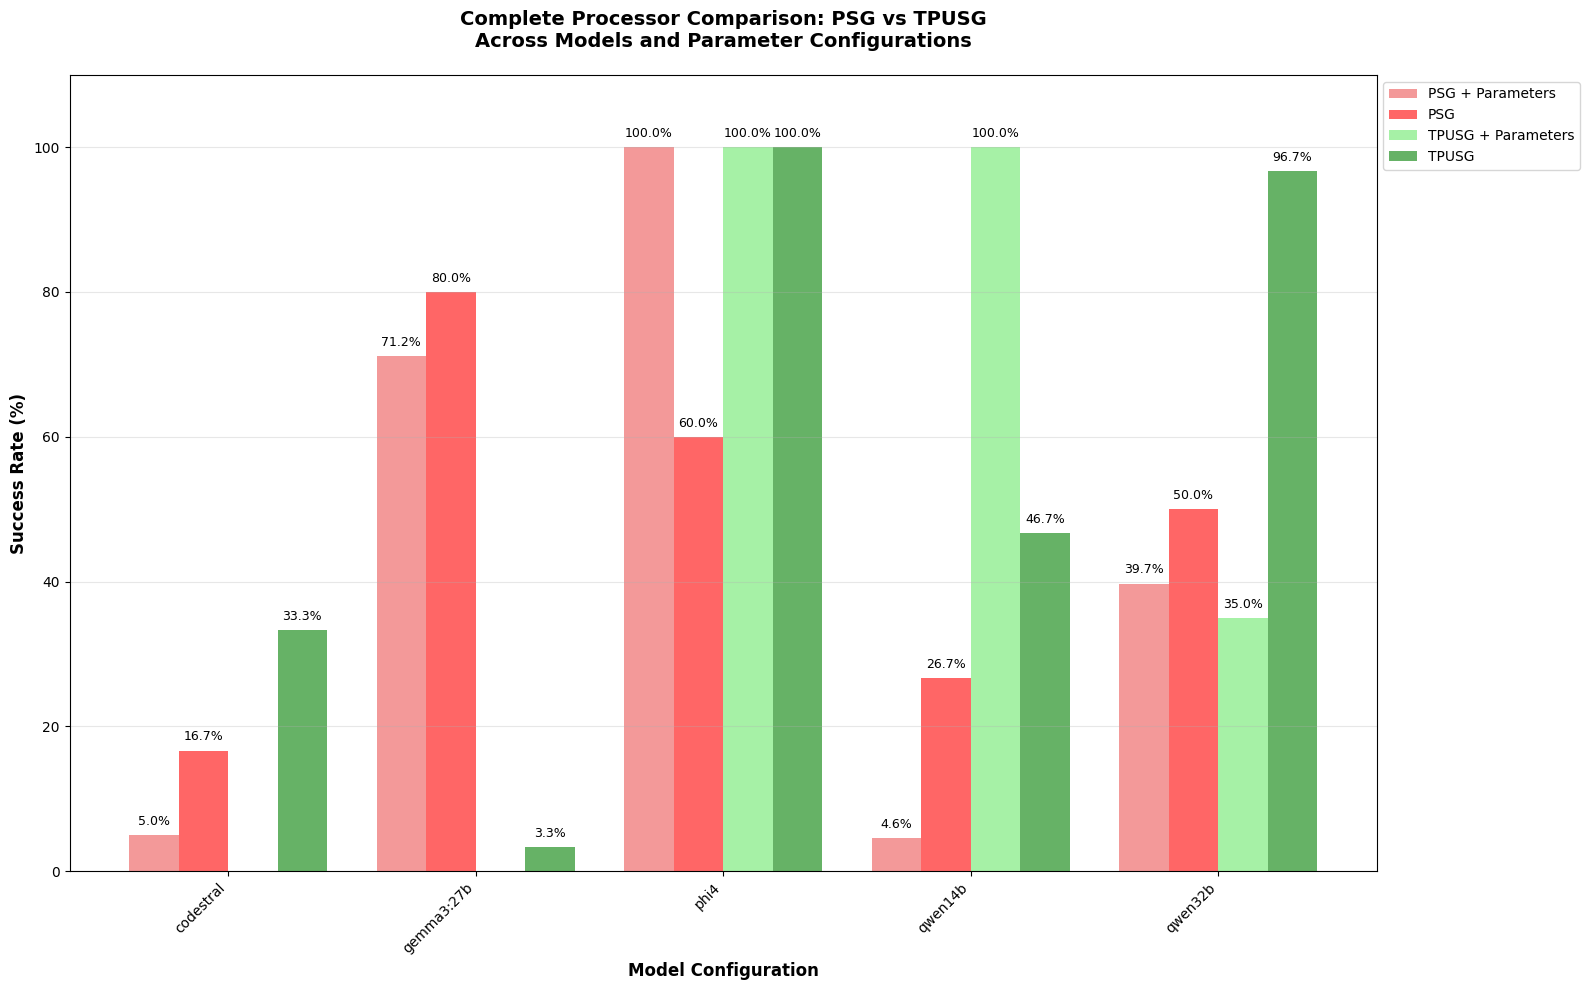


📈 SUMMARY COMPARISON TABLE:
--------------------------------------------------------------------------------
     Model PSG+Params   PSG TPUSG+Params  TPUSG  Best_Config
 codestral       5.0% 16.7%         0.0%  33.3%        TPUSG
gemma3:27b      71.2% 80.0%         0.0%   3.3%          PSG
      phi4     100.0% 60.0%       100.0% 100.0%   PSG+Params
   qwen14b       4.6% 26.7%       100.0%  46.7% TPUSG+Params
   qwen32b      39.7% 50.0%        35.0%  96.7%        TPUSG

✅ Complete processor comparison analysis finished!
📊 Chart shows all 5 models × 2 processors × 2 parameter conditions = 20 configurations


In [535]:
# Detailed Processor Comparison Chart
print("\n📊 DETAILED PROCESSOR COMPARISON BY MODEL & PARAMETERS")
print("=" * 70)

# Create comprehensive comparison chart
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for grouped bar chart
models = sorted(comparison_df['model_config'].unique())
x = np.arange(len(models))
width = 0.2

# Get data for each combination
psg_with_data = []
psg_without_data = []
tpusg_with_data = []
tpusg_without_data = []

for model in models:
    model_data = comparison_df[comparison_df['model_config'] == model]
    
    psg_with = model_data[(model_data['processor'] == 'psg') & (model_data['parameters'] == True)]['success_rate']
    psg_without = model_data[(model_data['processor'] == 'psg') & (model_data['parameters'] == False)]['success_rate']
    tpusg_with = model_data[(model_data['processor'] == 'tpusg') & (model_data['parameters'] == True)]['success_rate']
    tpusg_without = model_data[(model_data['processor'] == 'tpusg') & (model_data['parameters'] == False)]['success_rate']
    
    psg_with_data.append(psg_with.iloc[0] if len(psg_with) > 0 else 0)
    psg_without_data.append(psg_without.iloc[0] if len(psg_without) > 0 else 0)
    tpusg_with_data.append(tpusg_with.iloc[0] if len(tpusg_with) > 0 else 0)
    tpusg_without_data.append(tpusg_without.iloc[0] if len(tpusg_without) > 0 else 0)

# Create bars
bars1 = ax.bar(x - width*1.5, psg_with_data, width, 
               label='PSG + Parameters', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x - width*0.5, psg_without_data, width, 
               label='PSG', color='red', alpha=0.6)
bars3 = ax.bar(x + width*0.5, tpusg_with_data, width, 
               label='TPUSG + Parameters', color='lightgreen', alpha=0.8)
bars4 = ax.bar(x + width*1.5, tpusg_without_data, width, 
               label='TPUSG', color='green', alpha=0.6)

# Customize chart
ax.set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Complete Processor Comparison: PSG vs TPUSG\nAcross Models and Parameter Configurations', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(max(psg_with_data), max(psg_without_data), max(tpusg_with_data), max(tpusg_without_data)) * 1.1)

# Add value labels
def add_labels(bars, data):
    for bar, value in zip(bars, data):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, value + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

add_labels(bars1, psg_with_data)
add_labels(bars2, psg_without_data)
add_labels(bars3, tpusg_with_data)
add_labels(bars4, tpusg_without_data)

plt.tight_layout()
plt.show()

# Summary comparison table
print(f"\n📈 SUMMARY COMPARISON TABLE:")
print("-" * 80)

summary_data = []
for i, model in enumerate(models):
    summary_data.append({
        'Model': model,
        'PSG+Params': f"{psg_with_data[i]:.1f}%",
        'PSG': f"{psg_without_data[i]:.1f}%",
        'TPUSG+Params': f"{tpusg_with_data[i]:.1f}%",
        'TPUSG': f"{tpusg_without_data[i]:.1f}%",
        'Best_Config': max([
            ('PSG+Params', psg_with_data[i]),
            ('PSG', psg_without_data[i]),
            ('TPUSG+Params', tpusg_with_data[i]),
            ('TPUSG', tpusg_without_data[i])
        ], key=lambda x: x[1])[0]
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n✅ Complete processor comparison analysis finished!")
print(f"📊 Chart shows all {len(models)} models × 2 processors × 2 parameter conditions = {len(models)*4} configurations")


📈 BATCH SUCCESS RATE TIMELINE ANALYSIS
🔄 Processing batch timeline data...
📊 Analyzed 38 unique batches
📅 Date range: 2025-07-29 11:00 to 2025-08-12 21:06

📋 SAMPLE BATCH TIMELINE DATA:
--------------------------------------------------------------------------------
             batch_id processor model_config  parameters  total_runs  successes  success_rate test_date
   qwen32b_ae24_tpusg     tpusg      qwen32b       False          19         17         89.47     07.28
   qwen32b_4e11_tpusg     tpusg      qwen32b       False          11         11        100.00     07.28
 codestral_c8f6_tpusg     tpusg    codestral       False          30         10         33.33     07.28
   qwen32b_1974_tpusg     tpusg      qwen32b        True          30         18         60.00     07.29
     qwen32b_1974_psg       psg      qwen32b        True          30         13         43.33     07.29
      phi4_85a9_tpusg     tpusg         phi4       False          30         30        100.00     07.30
    

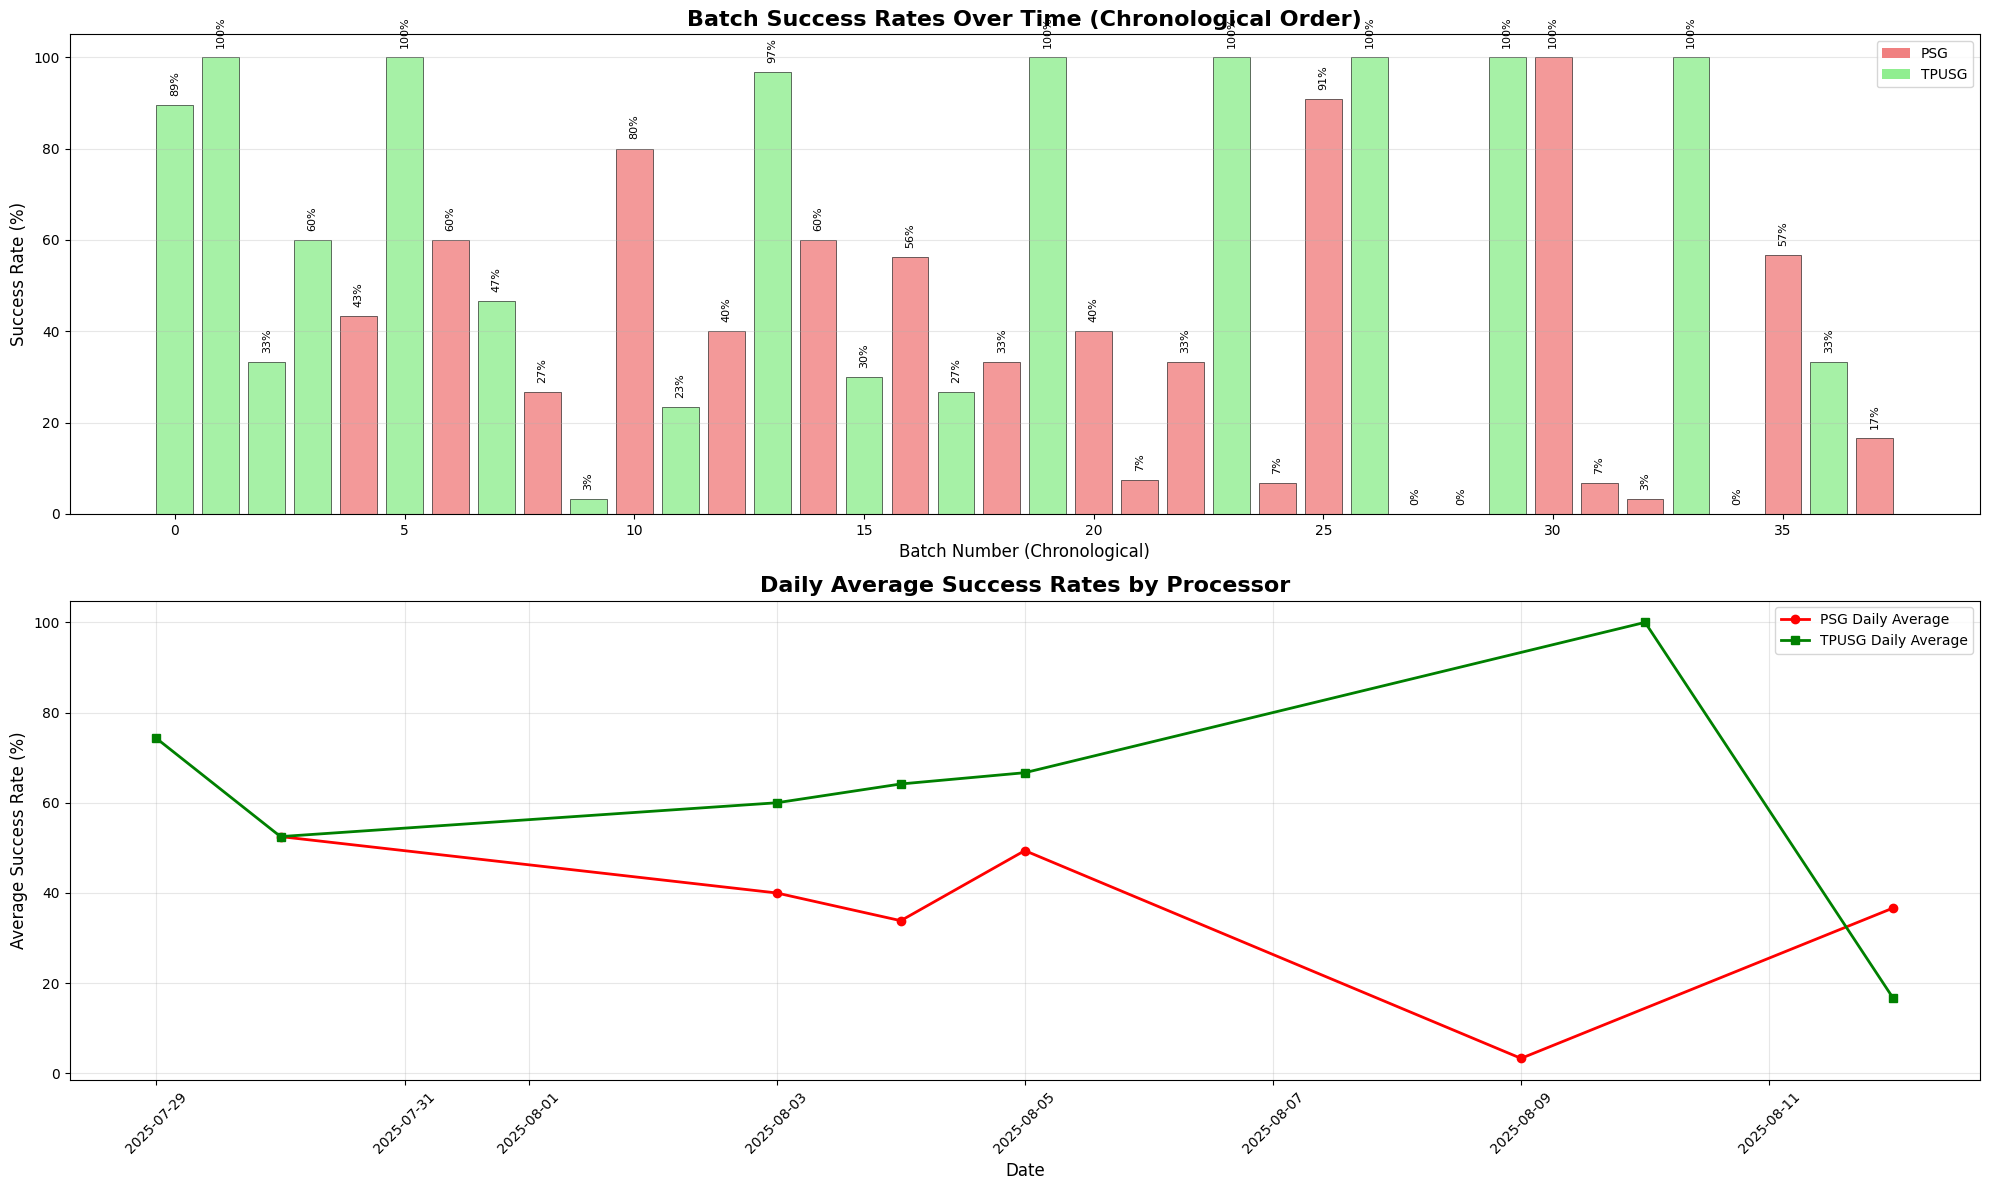


📊 BATCH TIMELINE SUMMARY:
--------------------------------------------------
Total unique batches: 38
Date range: 8 unique days

Processor breakdown:
  PSG batches: 19 (avg success: 40.1%)
  TPUSG batches: 19 (avg success: 60.1%)

🏆 Best performing batch:
  qwen32b_4e11_tpusg: 100.0% (tpusg, qwen32b)

📉 Worst performing batch:
  qwen14b_33b8_psg: 0.0% (psg, qwen14b)

✅ Batch timeline analysis complete!
📈 Timeline shows 38 batches across 13 processor-date combinations


In [536]:
# Batch Timeline Analysis Function
print("\n📈 BATCH SUCCESS RATE TIMELINE ANALYSIS")
print("=" * 70)

def analyze_batch_timeline(df):
    """
    Analyze success rates for each batch_id over time.
    Groups data by batch_id, calculates success rate, and uses earliest timestamp.
    """
    print("🔄 Processing batch timeline data...")
    
    # Group by batch_id and aggregate
    batch_analysis = df.groupby('batch_id').agg({
        'status': ['count', lambda x: (x == 'success').sum()],  # total runs and successes
        'timestamp': 'min',  # earliest timestamp in the batch
        'test_date': 'first',  # first test date
        'processor': 'first',  # processor type
        'model_config': 'first',  # model configuration
        'parameters': 'first'  # parameter setting
    }).reset_index()
    
    # Flatten column names
    batch_analysis.columns = ['batch_id', 'total_runs', 'successes', 'earliest_timestamp', 
                             'test_date', 'processor', 'model_config', 'parameters']
    
    # Calculate success rate
    batch_analysis['success_rate'] = (batch_analysis['successes'] / batch_analysis['total_runs'] * 100).round(2)
    
    # Convert timestamp to datetime for plotting
    batch_analysis['datetime'] = pd.to_datetime(batch_analysis['earliest_timestamp'], unit='s')
    
    # Sort by timestamp
    batch_analysis = batch_analysis.sort_values('earliest_timestamp')
    
    print(f"📊 Analyzed {len(batch_analysis)} unique batches")
    print(f"📅 Date range: {batch_analysis['datetime'].min().strftime('%Y-%m-%d %H:%M')} to {batch_analysis['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    
    return batch_analysis

def plot_batch_timeline(batch_data):
    """
    Create a timeline bar chart of batch success rates.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
    
    # Chart 1: All batches chronologically
    colors = ['lightcoral' if proc == 'psg' else 'lightgreen' for proc in batch_data['processor']]
    
    bars = ax1.bar(range(len(batch_data)), batch_data['success_rate'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax1.set_title('Batch Success Rates Over Time (Chronological Order)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Batch Number (Chronological)', fontsize=12)
    ax1.set_ylabel('Success Rate (%)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 105)
    
    # Add processor legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightcoral', label='PSG'),
                      Patch(facecolor='lightgreen', label='TPUSG')]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Add value labels for significant points
    for i, (rate, batch_id) in enumerate(zip(batch_data['success_rate'], batch_data['batch_id'])):
        if rate == 100 or rate == 0 or i % max(1, len(batch_data)//20) == 0:  # Label every ~20th bar or extremes
            ax1.text(i, rate + 2, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Chart 2: Daily aggregated success rates
    batch_data['date'] = batch_data['datetime'].dt.date
    daily_stats = batch_data.groupby(['date', 'processor']).agg({
        'success_rate': 'mean',
        'batch_id': 'count'
    }).reset_index()
    daily_stats.columns = ['date', 'processor', 'avg_success_rate', 'batch_count']
    
    # Create separate data for PSG and TPUSG
    psg_daily = daily_stats[daily_stats['processor'] == 'psg'].sort_values('date')
    tpusg_daily = daily_stats[daily_stats['processor'] == 'tpusg'].sort_values('date')
    
    # Plot daily averages
    if not psg_daily.empty:
        ax2.plot(psg_daily['date'], psg_daily['avg_success_rate'], 
                marker='o', linewidth=2, markersize=6, color='red', label='PSG Daily Average')
    
    if not tpusg_daily.empty:
        ax2.plot(tpusg_daily['date'], tpusg_daily['avg_success_rate'], 
                marker='s', linewidth=2, markersize=6, color='green', label='TPUSG Daily Average')
    
    ax2.set_title('Daily Average Success Rates by Processor', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Average Success Rate (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return daily_stats

# Execute the batch timeline analysis
batch_timeline_data = analyze_batch_timeline(df)

# Display sample of the data
print("\n📋 SAMPLE BATCH TIMELINE DATA:")
print("-" * 80)
sample_data = batch_timeline_data[['batch_id', 'processor', 'model_config', 'parameters', 
                                  'total_runs', 'successes', 'success_rate', 'test_date']].head(10)
print(sample_data.to_string(index=False))

# Create the timeline visualization
print(f"\n📈 CREATING BATCH TIMELINE VISUALIZATION...")
daily_summary = plot_batch_timeline(batch_timeline_data)

# Summary statistics
print(f"\n📊 BATCH TIMELINE SUMMARY:")
print("-" * 50)
print(f"Total unique batches: {len(batch_timeline_data)}")
print(f"Date range: {len(batch_timeline_data['datetime'].dt.date.unique())} unique days")

psg_batches = batch_timeline_data[batch_timeline_data['processor'] == 'psg']
tpusg_batches = batch_timeline_data[batch_timeline_data['processor'] == 'tpusg']

print(f"\nProcessor breakdown:")
print(f"  PSG batches: {len(psg_batches)} (avg success: {psg_batches['success_rate'].mean():.1f}%)")
print(f"  TPUSG batches: {len(tpusg_batches)} (avg success: {tpusg_batches['success_rate'].mean():.1f}%)")

# Best and worst performing batches
best_batch = batch_timeline_data.loc[batch_timeline_data['success_rate'].idxmax()]
worst_batch = batch_timeline_data.loc[batch_timeline_data['success_rate'].idxmin()]

print(f"\n🏆 Best performing batch:")
print(f"  {best_batch['batch_id']}: {best_batch['success_rate']:.1f}% ({best_batch['processor']}, {best_batch['model_config']})")

print(f"\n📉 Worst performing batch:")
print(f"  {worst_batch['batch_id']}: {worst_batch['success_rate']:.1f}% ({worst_batch['processor']}, {worst_batch['model_config']})")

print(f"\n✅ Batch timeline analysis complete!")
print(f"📈 Timeline shows {len(batch_timeline_data)} batches across {len(daily_summary)} processor-date combinations")


📊 DETAILED BATCH TIMELINE: WITH/WITHOUT PARAMETERS ANALYSIS
🔄 Creating parameter-separated visualizations...


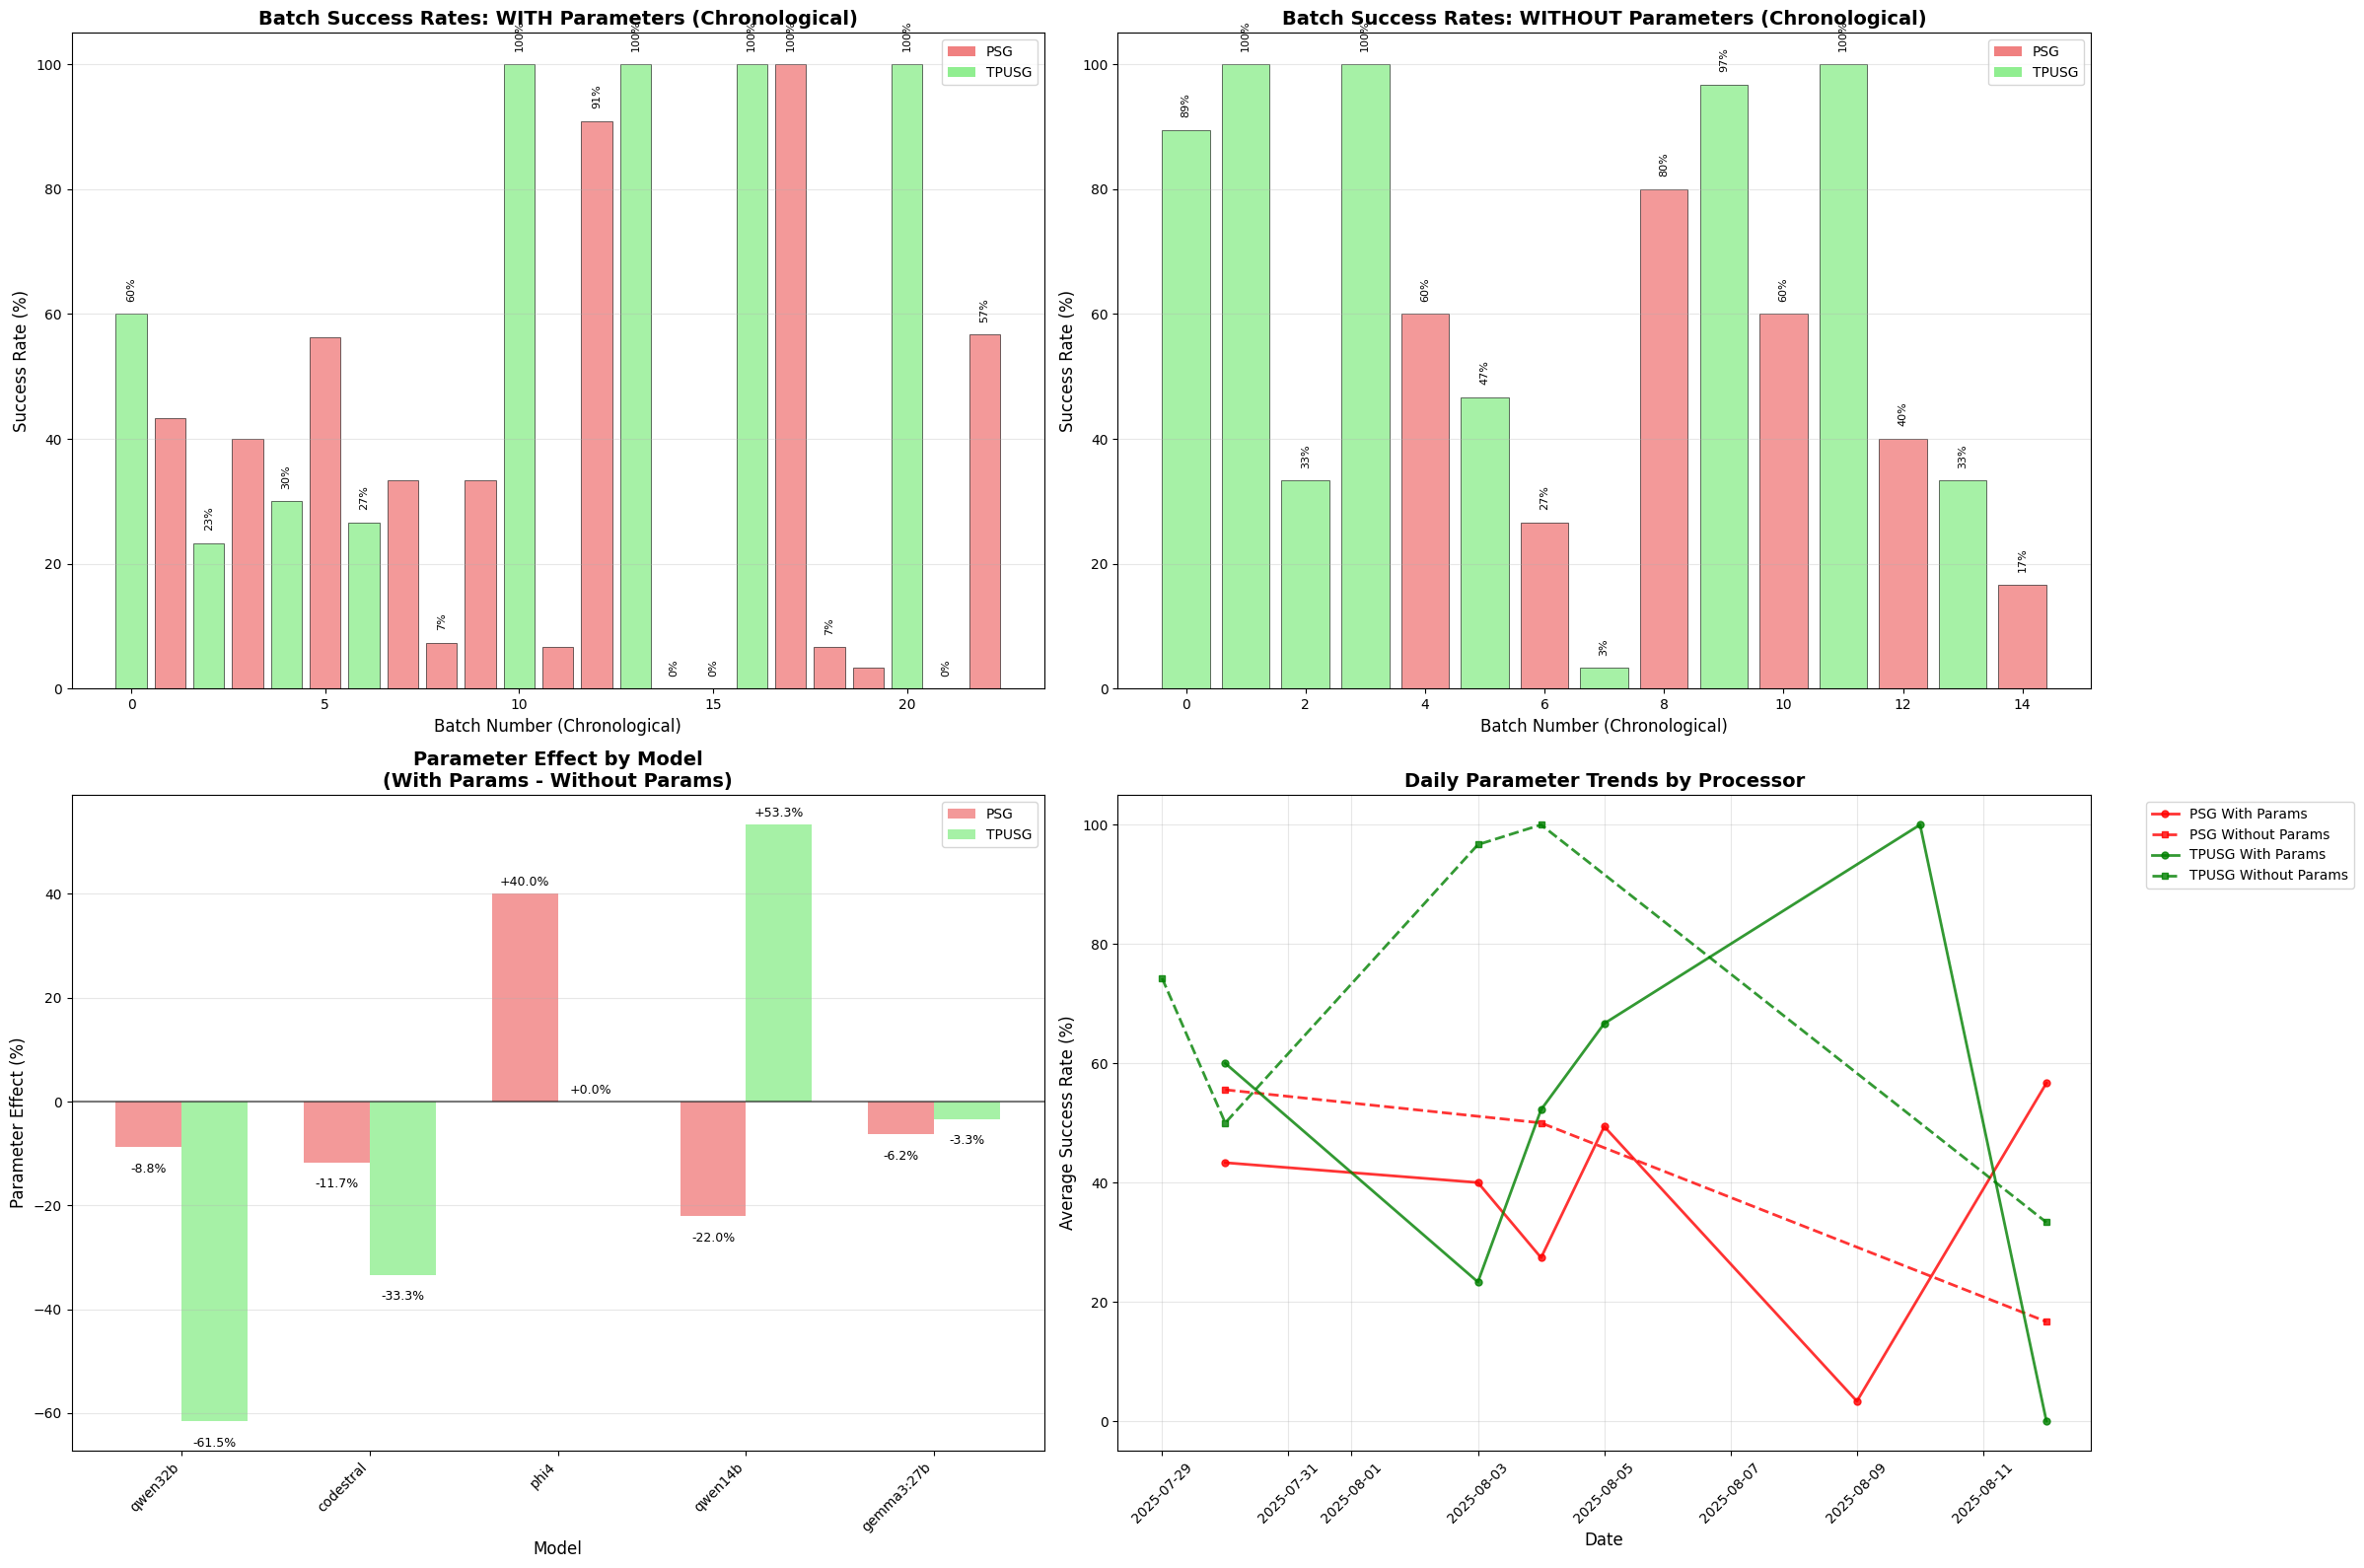


📊 PARAMETER-SPECIFIC BATCH SUMMARY:
------------------------------------------------------------
📈 WITH Parameters:
  Total batches: 23
  PSG: 13 batches (avg: 36.8%)
  TPUSG: 10 batches (avg: 54.0%)
  Best with params: qwen14b_3193_tpusg (100.0%)
  Worst with params: qwen14b_33b8_psg (0.0%)

📉 WITHOUT Parameters:
  Total batches: 15
  PSG: 6 batches (avg: 47.2%)
  TPUSG: 9 batches (avg: 67.0%)
  Best without params: qwen32b_4e11_tpusg (100.0%)
  Worst without params: gemma3:27b_85a9_tpusg (3.3%)

⚙️ PARAMETER EFFECT ANALYSIS:
--------------------------------------------------
qwen32b:
  PSG: 41.2% (with) vs 50.0% (without) → -8.8% effect
  TPUSG: 35.0% (with) vs 96.5% (without) → -61.5% effect
codestral:
  PSG: 5.0% (with) vs 16.7% (without) → -11.7% effect
  TPUSG: 0.0% (with) vs 33.3% (without) → -33.3% effect
phi4:
  PSG: 100.0% (with) vs 60.0% (without) → +40.0% effect
  TPUSG: 100.0% (with) vs 100.0% (without) → +0.0% effect
qwen14b:
  PSG: 4.7% (with) vs 26.7% (without) → -22.0

In [537]:
# Enhanced Batch Timeline Analysis: Parameter-Separated Visualization
print("\n📊 DETAILED BATCH TIMELINE: WITH/WITHOUT PARAMETERS ANALYSIS")
print("=" * 70)

def plot_detailed_parameter_timeline(batch_data):
    """
    Create detailed timeline charts separated by parameter conditions.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))
    
    # Separate data by parameters
    with_params = batch_data[batch_data['parameters'] == True].sort_values('earliest_timestamp')
    without_params = batch_data[batch_data['parameters'] == False].sort_values('earliest_timestamp')
    
    # Chart 1: With Parameters - Chronological
    if not with_params.empty:
        colors_with = ['lightcoral' if proc == 'psg' else 'lightgreen' for proc in with_params['processor']]
        bars1 = ax1.bar(range(len(with_params)), with_params['success_rate'], 
                       color=colors_with, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        ax1.set_title('Batch Success Rates: WITH Parameters (Chronological)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Batch Number (Chronological)', fontsize=12)
        ax1.set_ylabel('Success Rate (%)', fontsize=12)
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_ylim(0, 105)
        
        # Add processor legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightcoral', label='PSG'),
                          Patch(facecolor='lightgreen', label='TPUSG')]
        ax1.legend(handles=legend_elements, loc='upper right')
        
        # Add value labels for extremes and every few bars
        for i, (rate, batch_id) in enumerate(zip(with_params['success_rate'], with_params['batch_id'])):
            if rate == 100 or rate == 0 or i % max(1, len(with_params)//10) == 0:
                ax1.text(i, rate + 2, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=90)
    else:
        ax1.text(0.5, 0.5, 'No batches with parameters', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Batch Success Rates: WITH Parameters', fontsize=14, fontweight='bold')
    
    # Chart 2: Without Parameters - Chronological  
    if not without_params.empty:
        colors_without = ['lightcoral' if proc == 'psg' else 'lightgreen' for proc in without_params['processor']]
        bars2 = ax2.bar(range(len(without_params)), without_params['success_rate'], 
                       color=colors_without, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        ax2.set_title('Batch Success Rates: WITHOUT Parameters (Chronological)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Batch Number (Chronological)', fontsize=12)
        ax2.set_ylabel('Success Rate (%)', fontsize=12)
        ax2.grid(axis='y', alpha=0.3)
        ax2.set_ylim(0, 105)
        
        # Add processor legend
        legend_elements = [Patch(facecolor='lightcoral', label='PSG'),
                          Patch(facecolor='lightgreen', label='TPUSG')]
        ax2.legend(handles=legend_elements, loc='upper right')
        
        # Add value labels for extremes and every few bars
        for i, (rate, batch_id) in enumerate(zip(without_params['success_rate'], without_params['batch_id'])):
            if rate == 100 or rate == 0 or i % max(1, len(without_params)//10) == 0:
                ax2.text(i, rate + 2, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=90)
    else:
        ax2.text(0.5, 0.5, 'No batches without parameters', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Batch Success Rates: WITHOUT Parameters', fontsize=14, fontweight='bold')
    
    # Chart 3: Parameter Effect Comparison by Model
    model_param_comparison = []
    for model in batch_data['model_config'].unique():
        model_with = batch_data[(batch_data['model_config'] == model) & (batch_data['parameters'] == True)]
        model_without = batch_data[(batch_data['model_config'] == model) & (batch_data['parameters'] == False)]
        
        if not model_with.empty and not model_without.empty:
            psg_with = model_with[model_with['processor'] == 'psg']['success_rate'].mean() if not model_with[model_with['processor'] == 'psg'].empty else 0
            psg_without = model_without[model_without['processor'] == 'psg']['success_rate'].mean() if not model_without[model_without['processor'] == 'psg'].empty else 0
            tpusg_with = model_with[model_with['processor'] == 'tpusg']['success_rate'].mean() if not model_with[model_with['processor'] == 'tpusg'].empty else 0
            tpusg_without = model_without[model_without['processor'] == 'tpusg']['success_rate'].mean() if not model_without[model_without['processor'] == 'tpusg'].empty else 0
            
            model_param_comparison.append({
                'model': model,
                'psg_with': psg_with,
                'psg_without': psg_without,
                'tpusg_with': tpusg_with,
                'tpusg_without': tpusg_without,
                'psg_effect': psg_with - psg_without,
                'tpusg_effect': tpusg_with - tpusg_without
            })
    
    if model_param_comparison:
        param_df = pd.DataFrame(model_param_comparison)
        models = param_df['model']
        x = np.arange(len(models))
        width = 0.35
        
        bars3 = ax3.bar(x - width/2, param_df['psg_effect'], width, label='PSG', color='lightcoral', alpha=0.8)
        bars4 = ax3.bar(x + width/2, param_df['tpusg_effect'], width, label='TPUSG', color='lightgreen', alpha=0.8)
        
        ax3.set_title('Parameter Effect by Model\n(With Params - Without Params)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Model', fontsize=12)
        ax3.set_ylabel('Parameter Effect (%)', fontsize=12)
        ax3.set_xticks(x)
        ax3.set_xticklabels(models, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Add value labels
        for i, (p_eff, t_eff) in enumerate(zip(param_df['psg_effect'], param_df['tpusg_effect'])):
            ax3.text(i - width/2, p_eff + (1 if p_eff >= 0 else -3), f'{p_eff:+.1f}%', 
                    ha='center', va='bottom' if p_eff >= 0 else 'top', fontsize=9)
            ax3.text(i + width/2, t_eff + (1 if t_eff >= 0 else -3), f'{t_eff:+.1f}%', 
                    ha='center', va='bottom' if t_eff >= 0 else 'top', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'Insufficient data for parameter comparison', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Parameter Effect by Model', fontsize=14, fontweight='bold')
    
    # Chart 4: Daily Parameter Trends
    batch_data['date'] = batch_data['datetime'].dt.date
    daily_param_stats = batch_data.groupby(['date', 'processor', 'parameters']).agg({
        'success_rate': 'mean',
        'batch_id': 'count'
    }).reset_index()
    daily_param_stats.columns = ['date', 'processor', 'parameters', 'avg_success_rate', 'batch_count']
    
    # Plot trends for each processor-parameter combination
    for proc in ['psg', 'tpusg']:
        for param in [True, False]:
            data = daily_param_stats[(daily_param_stats['processor'] == proc) & (daily_param_stats['parameters'] == param)]
            if not data.empty:
                color = 'red' if proc == 'psg' else 'green'
                linestyle = '-' if param else '--'
                marker = 'o' if param else 's'
                label = f"{proc.upper()} {'With' if param else 'Without'} Params"
                
                ax4.plot(data['date'], data['avg_success_rate'], 
                        marker=marker, linewidth=2, markersize=5, color=color, 
                        linestyle=linestyle, label=label, alpha=0.8)
    
    ax4.set_title('Parameter Trends by Processor', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Average Success Rate (%)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return param_df if model_param_comparison else None

# Execute the detailed parameter timeline analysis
print("🔄 Creating parameter-separated visualizations...")
parameter_comparison = plot_detailed_parameter_timeline(batch_timeline_data)

# Parameter-specific summary statistics
print(f"\n📊 PARAMETER-SPECIFIC BATCH SUMMARY:")
print("-" * 60)

with_params_data = batch_timeline_data[batch_timeline_data['parameters'] == True]
without_params_data = batch_timeline_data[batch_timeline_data['parameters'] == False]

print(f"📈 WITH Parameters:")
print(f"  Total batches: {len(with_params_data)}")
if not with_params_data.empty:
    psg_with = with_params_data[with_params_data['processor'] == 'psg']
    tpusg_with = with_params_data[with_params_data['processor'] == 'tpusg']
    print(f"  PSG: {len(psg_with)} batches (avg: {psg_with['success_rate'].mean():.1f}%)")
    print(f"  TPUSG: {len(tpusg_with)} batches (avg: {tpusg_with['success_rate'].mean():.1f}%)")
    print(f"  Best with params: {with_params_data.loc[with_params_data['success_rate'].idxmax()]['batch_id']} ({with_params_data['success_rate'].max():.1f}%)")
    print(f"  Worst with params: {with_params_data.loc[with_params_data['success_rate'].idxmin()]['batch_id']} ({with_params_data['success_rate'].min():.1f}%)")

print(f"\n📉 WITHOUT Parameters:")
print(f"  Total batches: {len(without_params_data)}")
if not without_params_data.empty:
    psg_without = without_params_data[without_params_data['processor'] == 'psg']
    tpusg_without = without_params_data[without_params_data['processor'] == 'tpusg']
    print(f"  PSG: {len(psg_without)} batches (avg: {psg_without['success_rate'].mean():.1f}%)")
    print(f"  TPUSG: {len(tpusg_without)} batches (avg: {tpusg_without['success_rate'].mean():.1f}%)")
    print(f"  Best without params: {without_params_data.loc[without_params_data['success_rate'].idxmax()]['batch_id']} ({without_params_data['success_rate'].max():.1f}%)")
    print(f"  Worst without params: {without_params_data.loc[without_params_data['success_rate'].idxmin()]['batch_id']} ({without_params_data['success_rate'].min():.1f}%)")

# Parameter effect analysis
if parameter_comparison is not None and not parameter_comparison.empty:
    print(f"\n⚙️ PARAMETER EFFECT ANALYSIS:")
    print("-" * 50)
    for _, row in parameter_comparison.iterrows():
        print(f"{row['model']}:")
        print(f"  PSG: {row['psg_with']:.1f}% (with) vs {row['psg_without']:.1f}% (without) → {row['psg_effect']:+.1f}% effect")
        print(f"  TPUSG: {row['tpusg_with']:.1f}% (with) vs {row['tpusg_without']:.1f}% (without) → {row['tpusg_effect']:+.1f}% effect")

print(f"\n✅ Parameter-separated batch timeline analysis complete!")
print(f"📊 Analysis reveals parameter effects across {len(batch_timeline_data)} batches in timeline order")